Loading pre-trained model and encoded images...
4/4 [==============================] - 6s 890ms/step


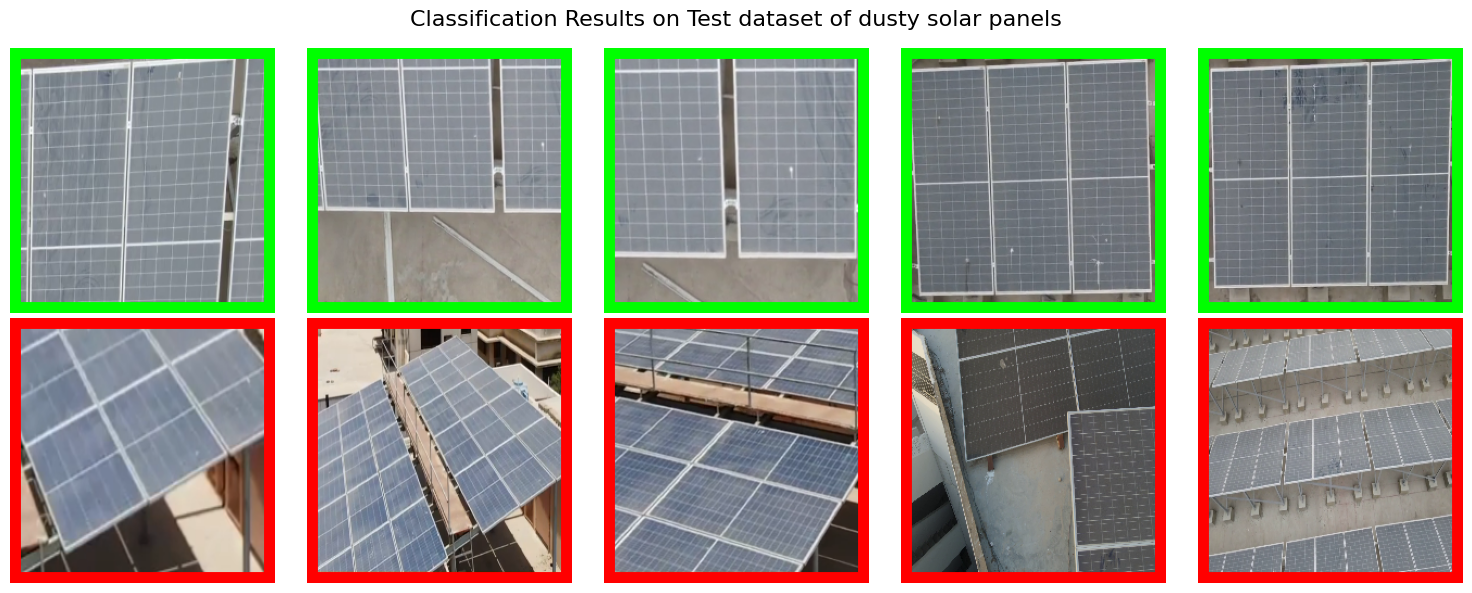

Accuracy: 0.8846153846153846
Precision: 1.0
Recall: 0.8846153846153846
F1-score: 0.9387755102040817


In [10]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from sklearn.preprocessing import LabelEncoder
import joblib  # For saving and loading models

# Paths for saved model and encoded data
model_path = 'svm_model.joblib'
encoded_images_path = 'encoded_images.npy'
labels_path = 'labels.npy'

# Load DenseNet169 model for feature extraction
base_model = DenseNet169(weights='imagenet', include_top=False)
model = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))

def load_images_from_folder(folder):
    images = []
    image_filenames = []  # Store image filenames for future reference
    labels = []
    valid_image_extensions = [".jpg", ".jpeg", ".png"]  # Only load supported image formats
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        ext = os.path.splitext(filename)[1].lower()
        if ext in valid_image_extensions:  # Only process valid image files
            img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)  # Load image as is (includes RGBA)
            if img is not None:
                # Convert RGBA or grayscale images to RGB
                if len(img.shape) == 2:  # Grayscale image (single channel)
                    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
                elif img.shape[2] == 4:  # RGBA image (4 channels)
                    img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)

                img = cv2.resize(img, (224, 224))  # Resize images to unified resolution
                img = img_to_array(img)
                img = preprocess_input(img)
                images.append(img)
                image_filenames.append(img_path)  # Store the image path for later display
                labels.append('dirty')  # Assuming all images in 'New_Test' are from the 'dirty' class
            else:
                print(f"Warning: Failed to load image {img_path}")
        else:
            print(f"Skipping non-image file: {filename}")
    
    if len(images) == 0:
        print(f"Error: No valid images found in folder {folder}")
    return np.array(images), np.array(labels), image_filenames

def encode_images(images, model):
    if images.size == 0:
        print("Error: No images found to encode.")
        return None
    encoded_images = model.predict(images)
    return encoded_images

def draw_bordered_image(img, color, thickness=10):
    """
    Draws a colored border around an image to act as a frame.
    Arguments:
    - img: The input image.
    - color: The color of the border (BGR format).
    - thickness: Thickness of the border.
    """
    bordered_img = cv2.copyMakeBorder(img, thickness, thickness, thickness, thickness, 
                                      cv2.BORDER_CONSTANT, value=color)
    return bordered_img

def display_images(image_paths, title, n=5):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle(title, fontsize=16)

    # Define colors for borders (BGR format for OpenCV)
    green = (0, 255, 0)  # Green for correct classifications
    red = (255, 0, 0)    # Red for wrong classifications

    # Correctly classified images (first row)
    for i, img_path in enumerate(image_paths['correct'][:n]):
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))  # Resize images to unified resolution
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_bordered = draw_bordered_image(img_rgb, green, thickness=10)  # Green border for correct classifications
        axes[0, i].imshow(img_bordered)
        axes[0, i].set_title("")
        axes[0, i].axis('off')

    # Wrongly classified images (second row)
    for i, img_path in enumerate(image_paths['wrong'][:n]):
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))  # Resize images to unified resolution
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_bordered = draw_bordered_image(img_rgb, red, thickness=10)  # Red border for wrong classifications
        axes[1, i].imshow(img_bordered)
        axes[1, i].set_title("")
        axes[1, i].axis('off')
    save_file_name = "visual_results.png"
    plt.tight_layout()
    fig.savefig(save_file_name, dpi=300)
    plt.show()

# Check if the model and encoded images are available
if os.path.exists(model_path) and os.path.exists(encoded_images_path) and os.path.exists(labels_path):
    print("Loading pre-trained model and encoded images...")
    best_model = joblib.load(model_path)
    encoded_images = np.load(encoded_images_path)
    labels = np.load(labels_path)
else:
    # Load images from 'mix/clean' and 'mix/dirty'
    mix_folder = 'mix'
    images, labels, _ = load_images_from_folder(mix_folder)

    # Check if any images were loaded
    if images.size == 0:
        print(f"Error: No images found in {mix_folder}")
    else:
        # Encode images using the modified DenseNet169 model
        encoded_images = encode_images(images, model)

        # Convert string labels to binary class labels
        label_encoder = LabelEncoder()
        binary_labels = label_encoder.fit_transform(labels)  # 'clean' -> 0, 'dirty' -> 1

        # Save encoded images and labels for future use
        np.save(encoded_images_path, encoded_images)
        np.save(labels_path, binary_labels)

        # Perform stratified cross-validation
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        best_model = None
        best_accuracy = 0
        for train_index, test_index in skf.split(encoded_images, binary_labels):
            X_train, X_test = encoded_images[train_index], encoded_images[test_index]
            y_train, y_test = binary_labels[train_index], binary_labels[test_index]

            # Train a linear SVM
            svm = SVC(kernel='linear')
            svm.fit(X_train, y_train)

            # Test the model
            y_pred = svm.predict(X_test)

            # Calculate accuracy
            accuracy = accuracy_score(y_test, y_pred)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model = svm

        # Save the trained SVM model
        joblib.dump(best_model, model_path)
        print(f"Model saved to {model_path}")

# Load the new "Dirty" class dataset from "New_Test"
new_folder = 'New_Test'
new_images, new_labels, new_image_filenames = load_images_from_folder(new_folder)

# Check if any images were loaded
if new_images.size == 0:
    print(f"Error: No images found in {new_folder}")
else:
    # Encode new dataset images using the modified model
    encoded_new_images = encode_images(new_images, model)

    if encoded_new_images is not None:
        # Test the best model on the "Dirty" class dataset
        new_pred = best_model.predict(encoded_new_images)

        # Assuming all images in "New Folder" are from the 'dirty' class
        true_labels = np.ones_like(new_pred)  # All are 'dirty' (1)

        # Identify correct and wrong classifications
        correct_indices = np.where(new_pred == true_labels)[0]
        wrong_indices = np.where(new_pred != true_labels)[0]

        correct_filenames = [new_image_filenames[i] for i in correct_indices]
        wrong_filenames = [new_image_filenames[i] for i in wrong_indices]

        # Organize filenames into dictionary
        image_paths = {
            'correct': correct_filenames,
            'wrong': wrong_filenames
        }

        # Display 5 correct and 5 wrong images with colored borders
        display_images(image_paths, "Classification Results on Test dataset of dusty solar panels", n=5)

        # Calculate metrics for the 'dirty' class
        accuracy = accuracy_score(true_labels, new_pred)
        precision = precision_score(true_labels, new_pred, pos_label=1)
        recall = recall_score(true_labels, new_pred, pos_label=1)
        f1 = f1_score(true_labels, new_pred, pos_label=1)

        # Display the results
        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1-score: {f1}")
